# Jet Compression using an Autoencoder

In [1]:
import sys
BIN = '../../'
sys.path.append(BIN)
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

from my_nn_modules import AE_big, get_data, fit

import my_matplotlib_style as ms
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

In [2]:
force_cpu = False

if force_cpu:
    device = torch.device('cpu')
else:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


## Loading and preparing the data

In [3]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/train.pkl')
test = pd.read_pickle(BIN + 'processed_data/test.pkl')

train.head(10)

,pT,eta,phi,E
1367643,300.752869,0.118391,-1.460827,303.719818
1739612,79.819145,4.535507,-1.185196,3722.832764
546066,220.472305,1.314261,-0.943992,440.195190
213212,74.533775,0.010658,-0.424795,74.770332
150544,220.668121,2.432910,-2.308348,1266.681030
574837,159.841782,0.731125,-1.150598,207.133514
1171687,306.125305,0.702473,0.437615,385.713013
1608254,189.011673,-1.387443,0.490634,403.126709
1618830,194.996719,-1.022815,-1.560437,306.534515
637947,186.887146,-0.621282,-0.465523,226.002701


## Normalizing and splitting into train and test datasets

In [4]:
np.max(train)

pT      20721.585938
eta         4.785440
phi         3.141583
E      146259.562500
dtype: float32

In [5]:
train.mean()

pT     226.349228
eta     -0.021712
phi      0.008840
E      596.682495
dtype: float32

In [6]:
# Normalize
train_mean = train.mean()
train_std = train.std()
#train_max = np.max(train)

train = (train - train_mean) / train_std
#train = (train - train_mean) / train_max
test = (test - train_mean) / train_std
#test = (test - train_mean) / train_max

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

## Training

In [7]:
bs = 256  # batch size
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
loss_func = nn.MSELoss()

In [8]:
n_features = len(train.loc[0])
model_big = AE_big(n_features=n_features)

In [9]:
# Training
epochs_list = [7, 5, 3, 2, 2]
lrs = [1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
train_losses = []
val_losses = []
for ii, epochs in enumerate(epochs_list):
    print('Setting learning rate to %.1e' % lrs[ii])
    opt = optim.Adam(model_big.parameters(), lr=lrs[ii])
    epoch_train_losses, epoch_val_losses = fit(epochs, model_big, loss_func, opt, train_dl, valid_dl, device)
    train_losses = train_losses + epoch_train_losses
    val_losses = val_losses + epoch_val_losses

Setting learning rate to 1.0e-03
Epoch 0: Train loss = 0.1307337255215554    Validation loss = 0.003815950454995639 Time: 0:00:55.453895
Epoch 1: Train loss = 0.020973946688433425    Validation loss = 0.0011853450666001863 Time: 0:01:44.436904
Epoch 2: Train loss = 0.019942676056736924    Validation loss = 0.0008335055814693718 Time: 0:02:27.977501
Epoch 3: Train loss = 0.01957662694668553    Validation loss = 0.000773683602135293 Time: 0:02:59.488084
Epoch 4: Train loss = 0.01937725669432551    Validation loss = 0.0005852946207740646 Time: 0:03:30.051602
Epoch 5: Train loss = 0.019190073521104363    Validation loss = 0.000584822390660289 Time: 0:04:02.846911
Epoch 6: Train loss = 0.01908292991234146    Validation loss = 0.000603925237035243 Time: 0:04:35.377532
Setting learning rate to 3.0e-04
Epoch 0: Train loss = 0.018854642858816106    Validation loss = 0.000375506598095789 Time: 0:00:31.020593
Epoch 1: Train loss = 0.018800849309454835    Validation loss = 0.0003648545286996689 Ti

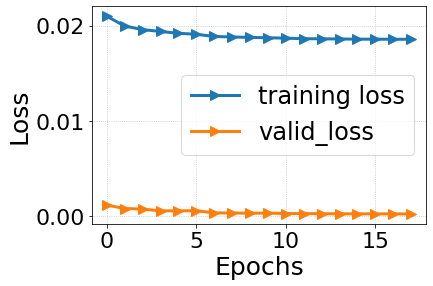

In [10]:
plt.plot(train_losses[1:], marker='>', label='training loss')
plt.plot(val_losses[1:], marker='>', label='valid_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [11]:
# saving the model for later inference (if training is to be continued another saving method is recommended)
# save_path = './models/AE_big_model_loss48eneg6.pt'
# torch.save(model_big.state_dict(), save_path)
# model_big = AE_big()
# model_big.load_state_dict(torch.load(save_path))
# model_big.eval()

## Evaluation

In [12]:
model_big.eval()

AE_big(
  (en1): Linear(in_features=4, out_features=8, bias=True)
  (en2): Linear(in_features=8, out_features=6, bias=True)
  (en3): Linear(in_features=6, out_features=4, bias=True)
  (en4): Linear(in_features=4, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=4, bias=True)
  (de2): Linear(in_features=4, out_features=6, bias=True)
  (de3): Linear(in_features=6, out_features=8, bias=True)
  (de4): Linear(in_features=8, out_features=4, bias=True)
  (tanh): Tanh()
)

In [13]:
# Print a few tensors, still normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model_big(data)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([ 1.6863, -0.7095,  1.6946,  0.2721])
Out: tensor([ 1.6872, -0.6988,  1.6899,  0.2795], grad_fn=<AddBackward0>)
 
Inp: tensor([ 0.1766, -0.1649, -0.0310, -0.5931])
Out: tensor([ 0.1821, -0.1625, -0.0365, -0.6049], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3746,  0.6508,  1.3037, -0.5510])
Out: tensor([-0.3647,  0.6445,  1.3064, -0.5471], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.3711, -0.0072,  1.0894, -0.7293])
Out: tensor([-0.3808, -0.0077,  1.0892, -0.7315], grad_fn=<AddBackward0>)
 
Inp: tensor([-0.7818, -0.3965,  1.1572, -0.7662])
Out: tensor([-0.7955, -0.3924,  1.1588, -0.7655], grad_fn=<AddBackward0>)
 


In [14]:
# Print a few tensors, now not normalized
print('Comparing input and output:')
for ii in np.arange(100, 105):
    data = valid_ds.tensors[0][ii]
    pred = model_big(data).detach().numpy()
    pred = np.multiply(pred, train_std.values)
#    pred = np.multiply(pred, train_max.values)
    pred = np.add(pred, train_mean.values)
    data = np.multiply(data, train_std.values)
#    data = np.multiply(data, train_max.values)
    data = np.add(data, train_mean.values)
    print('Inp:', data)
    print('Out:', pred)
    print(' ')

Comparing input and output:
Inp: tensor([430.8397,  -1.1533,   3.0955, 751.4479])
Out: [430.94632    -1.1363106   3.0868638 755.63104  ]
 
Inp: tensor([ 2.4776e+02, -2.8475e-01, -4.7715e-02,  2.5939e+02])
Out: [ 2.4843079e+02 -2.8084791e-01 -5.7585794e-02  2.5269574e+02]
 
Inp: tensor([180.9266,   1.0163,   2.3835, 283.3568])
Out: [182.121       1.006177    2.3883853 285.5602   ]
 
Inp: tensor([ 1.8135e+02, -3.3156e-02,  1.9931e+00,  1.8195e+02])
Out: [ 1.8016776e+02 -3.3965711e-02  1.9926767e+00  1.8066754e+02]
 
Inp: tensor([131.5479,  -0.6542,   2.1167, 160.9622])
Out: [129.87675     -0.64749396   2.1195     161.35101   ]
 


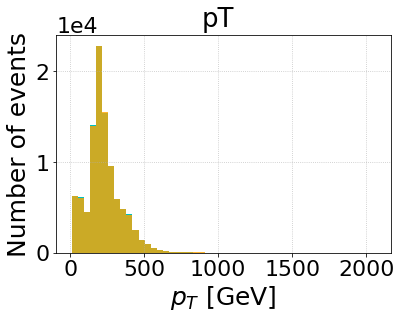

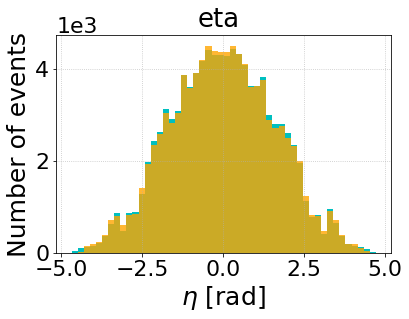

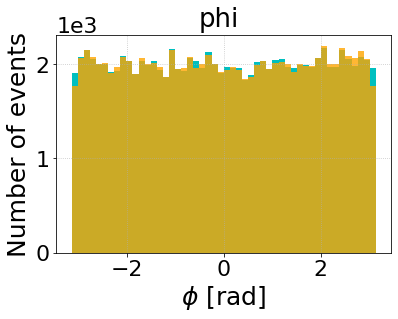

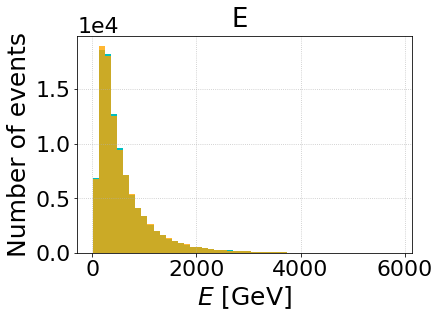

In [15]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']


# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model_big(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
#pred = np.multiply(pred, train_max.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
#data = np.multiply(data, train_max.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()

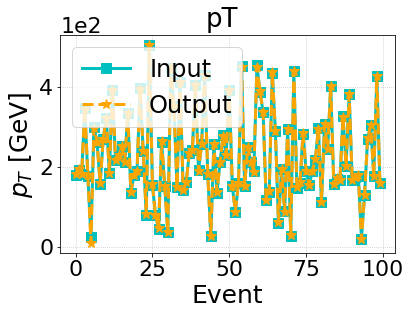

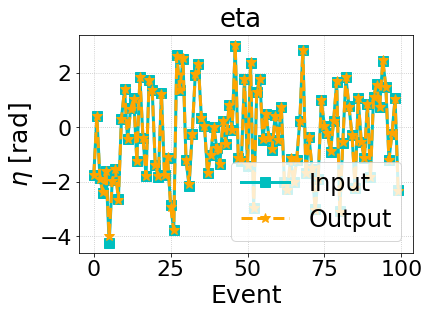

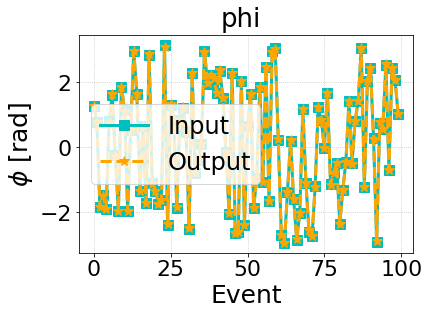

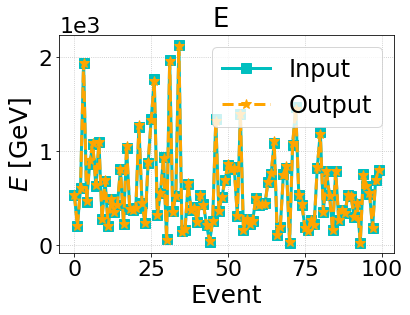

In [16]:
# Plot input on top of output
idxs = (0, 100)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model_big(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
#pred = np.multiply(pred, train_max.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
#data = np.multiply(data, train_max.values)
data = np.add(data, train_mean.values)

for kk in np.arange(4):
    plt.figure(kk)
    plt.plot(data[:, kk], color=colors[1], label='Input', linestyle=line_style[1], marker=markers[1])
    plt.plot(pred[:, kk], color=colors[0], label='Output', linestyle=line_style[0], marker=markers[0])
    plt.suptitle(train.columns[kk])
    plt.xlabel('Event')
    plt.ylabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.legend()
    ms.sciy()